# Differentiable Programming 

This tutorial aims to take you through the basics of writing a differentiable program using PyTorch and to highlight some of the ways to use this type of tool. If you've trained a neural network, you've already written a differentiable program! But we will try to show the power of generalizing beyond neural networks, and to bring out some subtleties that you don't usually have to worry about. The tutorial is structured as follows:

1. **Introduction: Parameter Fitting** We begin with a simple example of fitting parameters of a differentiable physics simulator using gradient-based optimization. The ingredients here should look familiar, just composed in a different way.


2. **Tips and Tricks: Hard Edges and You** Not everything is (nicely) differentiable! What are some ways to deal with that?


3. **Bonus: Differentiable Pipelines** A powerful use of differentiable programming is to use physics code in conjunction with neural networks. We present a simple example how how these elements might be composed.


## Introduction: Parameter Fitting

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from tqdm import tqdm

### A simple physics model

Suppose we want to simulate the motion of a ball. More specifically, for each time $t$, we would like to know the position, $\vec{x}$ of an object, perhaps under some acceleration $\vec{a}$.

Kinematic equations tell us:
\begin{equation}
\vec{x}(t) = \vec{x}_{0} + \vec{v}_{0}t + \frac{1}{2}\vec{a}t^2
\end{equation}

where $\vec{x}_{0}$ and $\vec{v}_{0}$ are the initial position/velocity.

In code: 

In [2]:
def position(t, a, x0, v0):
    return x0 + v0*t + 0.5*a*t**2

Sticking to 2d for visualization purposes, we can run a simple simulation to get the trajectory of an object under the influence of gravity, namely:

$\vec{a}$ = (0, -9.8), in units of $m / s^2$

In [3]:
#Acceleration due to gravity (-9.8 m/s^2 in negative y direction)
a = np.asarray([0, -9.8])

#Initial velocity for fun (m / s)
v0 = np.asarray([5, 10])

#Start at (0,10) [m]
x0 = np.asarray([0,10])

We then can create a trajectory for the object by "measuring" position at a set of time steps

In [4]:
#Run the simulation: 100 timesteps
time_steps = np.linspace(0, 5, 10)

trajectory = []
for t_step in time_steps:
    xt = position(t_step, a, x0, v0)
    trajectory.append(xt)
    
trajectory = np.asarray(trajectory)

For fun, let's animate how this might look:

In [5]:
xlim = [trajectory[:, 0].min(), trajectory[:, 0].max()]
ylim = [trajectory[:, 1].min(), trajectory[:, 1].max()]

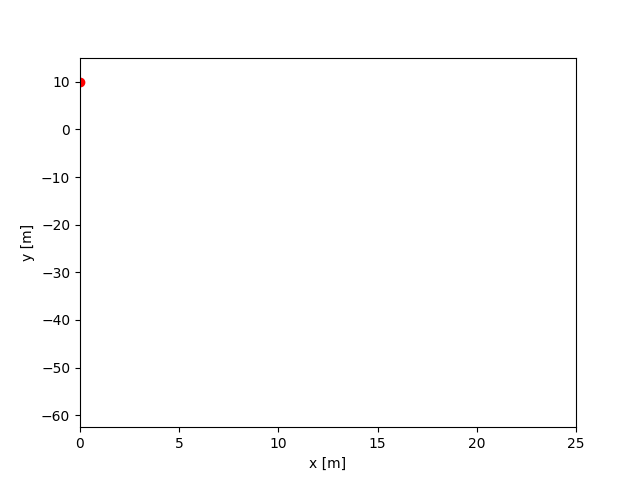

In [6]:
%matplotlib widget

fig, ax = plt.subplots()

dot, = ax.plot([x0[0]], [x0[1]], 'ro')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')

def animate(time_step):
    dot.set_data([trajectory[time_step, 0]], [trajectory[time_step, 1]])
    return dot,

anim = FuncAnimation(fig, animate, frames=len(time_steps), repeat=True)
plt.show()

Or, just plotting all time steps:

In [7]:
plt.close()

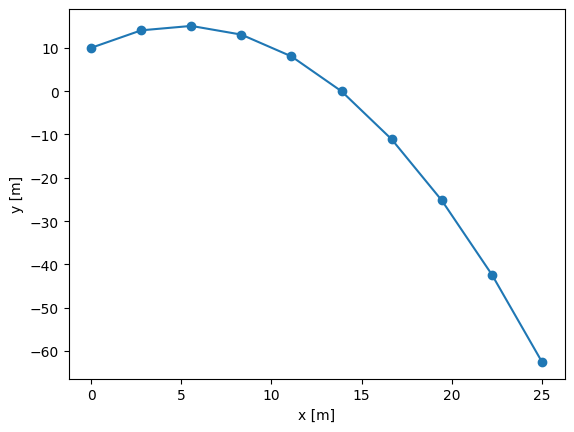

In [8]:
%matplotlib inline
plt.plot(trajectory[:, 0], trajectory[:, 1], '-o')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.show()

We now have a physics simulator (albeit a simple one)! 

### Terminology: 
In the ML context, we call the above simulator our **forward model**, namely: we start from some set of conditions, and we use the forward model to get some result.

### Today: 
Imagine we know the forward model, and we have some dataset. In a real context, this could correspond to experimental data, where the forward model is the physics simulation. How can we use the forward model to gain insight into the experimental data? More particularly, can we use the forward model to extract physical parameters from the real dataset? This is where differentiable simulation can be useful! Notable examples: detector calibration, physics reconstruction.

### In our case:
Suppose we're given some kinematic trajectory, but we don't know the initial velocity? Or the acceleration? Or the initial position? A differentiable kinematics simulator provides an easy tool to extract these parameters. Let's see how this works.

### Step 1: Differentiable forward model

We'll use PyTorch here, but the same concepts apply to any framework

In [9]:
import torch

### Convenience step: Vectorization
PyTorch is a tensor library! In principle, for loops are ok, but often slower/less nice for GPU acceleration.

Our data: single 2D kinematic trajectory with measurements at `n_steps` time steps $\implies$ the output of the simulation should have shape `(n_steps, 2)`.

In [10]:
trajectory.shape

(10, 2)

Repeating here for clarity, but: position function can stay the same!

In [11]:
def position(t, a, x0, v0):
    return x0 + v0*t + 0.5*a*t**2

However, we need to adjust the shapes to work.

Think of time as the zeroth dimension, spatial coordinates as the first dimension. Then, if we define our parameters as:

In [12]:
#Acceleration due to gravity (-9.8 m/s^2 in negative y direction)
a = torch.tensor([0, -9.8])[None, :]

#Initial velocity for fun (m / s)
v0 = torch.tensor([5, 10])[None, :]

#Start at (0,10) [m]
x0 = torch.tensor([0,10])[None, :]

In [13]:
a.shape

torch.Size([1, 2])

and our timesteps as:

In [14]:
#Run the simulation: 10 timesteps
time_steps = torch.linspace(0, 5, 10)[:, None]

In [15]:
time_steps.shape

torch.Size([10, 1])

Broadcasting will then give us the desired shape

In [16]:
trajectory = position(time_steps, a, x0, v0)

In [17]:
print(trajectory.shape)

torch.Size([10, 2])


and we haven't changed any values, so the output should be identical

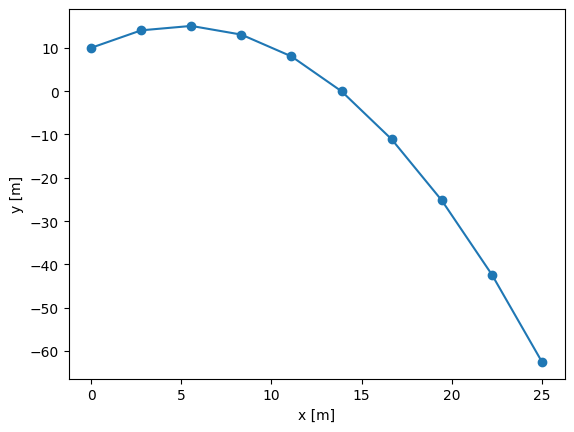

In [18]:
plt.plot(trajectory[:, 0], trajectory[:, 1], '-o')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.show()

### Summary: 

Things are easy for us today! Our forward model is a single function, `position`, which takes in measurement times, acceleration, initial position, and initial velocity, and returns a trajectory ($x$ and $y$ positions at each time step).

Note that this is trivially differentiable -- we only use addition and multiplication! A more complicated simulation might require more tricks.

### Step 2: "Take" some data

For today, we'll be using a single trajectory with some given parameter values as our target. This is the most perfect case -- our forward model is exact and we know the true parameter values. Real life is more complicated, but everybody starts somewhere!

Let's use the same trajectory as above, but recording for posterity:

In [19]:
#Acceleration due to gravity (-9.8 m/s^2 in negative y direction)
a_target = torch.tensor([0, -9.8])[None, :]

#Initial velocity for fun (m / s)
v0_target = torch.tensor([5, 10])[None, :]

#Start at (0,10) [m]
x0_target = torch.tensor([0,10])[None, :]

#Data taken at 10 known timesteps from 0 to 5 s
time_steps = torch.linspace(0, 5, 10)[:, None]

Target is the corresponding trajectory

In [20]:
trajectory_target = position(time_steps, a_target, x0_target, v0_target)

### Step 3: Set up parameter gradients

To start, let's try to solve for the **initial velocity**. We need to set up a new forward model with an initial guess. We can then iterate over the new model parameters.


We assume only v0 changes for now, so everything else is the same

In [21]:
#Acceleration due to gravity (-9.8 m/s^2 in negative y direction)
a_guess = torch.tensor([0, -9.8])[None, :]

#Start at (0,10) [m]
x0_guess = torch.tensor([0.,10.])[None, :]

#Run the simulation: 10 timesteps
time_steps = torch.linspace(0, 5, 10)[:, None]

And we don't know v0, so let's initialize to (0, 0)

In [22]:
#Initial velocity for fun (m / s)
v0_guess = torch.tensor([0., 0.])[None, :]

Now we need a training loop. There are two important pieces:

1. A **loss function**: in this case the easiest is just the Mean Squared Error between the output of the "guess" forward model and the target trajectory.

2. An **optimizer**: how do we change parameters to try to fit the trajectory? Let's start with a simple gradient descent.

Recall that gradient descent for some parameter (or vector of parameters) $\theta$ at training step $i$ has update rule:

\begin{equation}
\theta_{i+1} = \theta_{i} - \eta\cdot\nabla_{\theta}f(\theta_i)
\end{equation}

where $f$ is our objective function, and $\eta$ is a _learning rate_ which controls the size of the gradient step. 

To do gradient descent, we need to keep track of gradients. In PyTorch this is done with setting `requires_grad = True` for the relevant parameters, either as an argument to `torch.tensor` in the initialization, or after the fact, like:

In [23]:
v0_guess.requires_grad = True

Gradients of `v0_guess` are accessible via the attribute `v0_guess.grad`. Right now, this isn't populated (`v0_guess` hasn't interacted with the physics model/we haven't done the backward autodiff pass). 

In [24]:
print(v0_guess.grad)

None


This may all be somewhat familiar from training neural networks, and it should be -- it's doing the same thing! However many of these details are abstracted away. We'll set up an explicit example below (before we do some abstraction ourselves).

### The training loop

There are a few steps in the typical autodiff training loop. First, we need to initialize the parameters we want to fit -- we already did this above, but just to keep everything together, let's repeat.

### Fixed parameters:
For simplicity, we're only fitting v0 for now

In [25]:
#Acceleration due to gravity (-9.8 m/s^2 in negative y direction)
a_guess = torch.tensor([0, -9.8])[None, :]
a_guess.requires_grad = False

#Start at (0,10) [m]
x0_guess = torch.tensor([0.,10.])[None, :]
x0_guess.requires_grad = False

#Run the simulation: 10 timesteps
time_steps = torch.linspace(0, 5, 10)[:, None]
time_steps.requires_grad = False

### Not fixed parameters:
We want to solve for `v0_guess`

In [26]:
#Initial velocity for fun (m / s)
v0_guess = torch.tensor([0., 0.])[None, :]
v0_guess.requires_grad = True

Then we make a guess with the initial parameters. This is done with a simple pass through the forward model

In [27]:
trajectory_guess = position(time_steps, a_guess, x0_guess, v0_guess)

Then compute the loss between the guessed trajectory and the target

In [28]:
loss = ((trajectory_target - trajectory_guess)**2).mean()

and let PyTorch accumulate gradients with a backward pass. Note that the backward pass starts at the loss calculation -- this is the thing we want to minimize with gradient descent.

In [29]:
loss.backward()

`v0_guess` now has an associated gradient

In [30]:
print(v0_guess.grad)

tensor([[-43.9815, -87.9630]])


and we expect a velocity of order 10, so let's define a learning rate so that our updates are of appropriate size

In [31]:
lr = 0.1

This allows us to actually do the update of `v0_guess`. We don't want to keep track of gradients through this update, so we wrap this in a `with torch.no_grad()`

In [32]:
with torch.no_grad():
    v0_guess -= lr*v0_guess.grad

`v0_guess` now has an updated value, so we can repeat. Note that, similar to training a neural network, we need to zero out the parameter gradients before the next iteration.

In [33]:
print(v0_guess)

tensor([[4.3981, 8.7963]], requires_grad=True)


### Exercise 1: Combine all of that into a loop

In [34]:
# Initialize training parameters
v0_guess = torch.tensor([0, 0], dtype=torch.float32)[None, :]
v0_guess.requires_grad = True

# Learning rate -- controls the size of the optimization step
lr = 1e-1


# Keep track of training and losses 
training_path = []
losses = []
v0_steps = []

# Do 10 parameter updates
for epoch in range(10):  
    
    # Zero out the gradients
    if v0_guess.grad is not None:
        v0_guess.grad.zero_()
        
    # Guess with current parameters
    trajectory_guess = position(time_steps, a_guess, x0_guess, v0_guess)
    
    
    # Calculate loss
    loss = ((trajectory_target - trajectory_guess)**2).mean()

    
    # Compute gradients
    loss.backward()    


    # Update for next loop
    with torch.no_grad():
        v0_guess -= lr*v0_guess.grad

        
    # Monitoring and history tracking
    print(f"Iter {epoch}, Loss: {loss.detach().item()}")
    training_path.append(trajectory_guess.detach())
    losses.append(loss.item())
    v0_steps.append(v0_guess.detach().clone())

Iter 0, Loss: 549.7685546875
Iter 1, Loss: 7.965602874755859
Iter 2, Loss: 0.11541344225406647
Iter 3, Loss: 0.0016722932923585176
Iter 4, Loss: 2.4222641513915733e-05
Iter 5, Loss: 3.5063058589912544e-07
Iter 6, Loss: 5.1636561693158e-09
Iter 7, Loss: 8.171809756651882e-11
Iter 8, Loss: 8.782308105574621e-13
Iter 9, Loss: 0.0


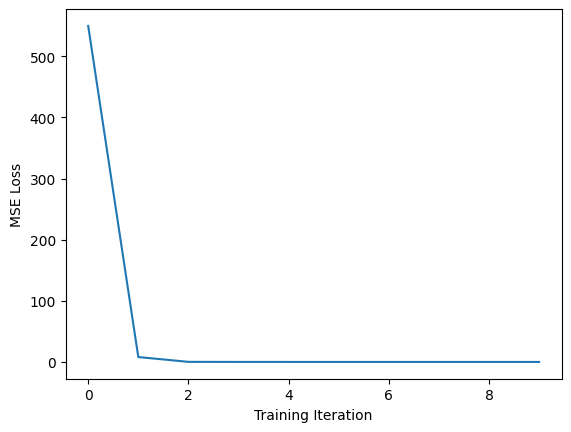

In [35]:
plt.plot(losses)
plt.xlabel('Training Iteration')
plt.ylabel('MSE Loss')
plt.show()

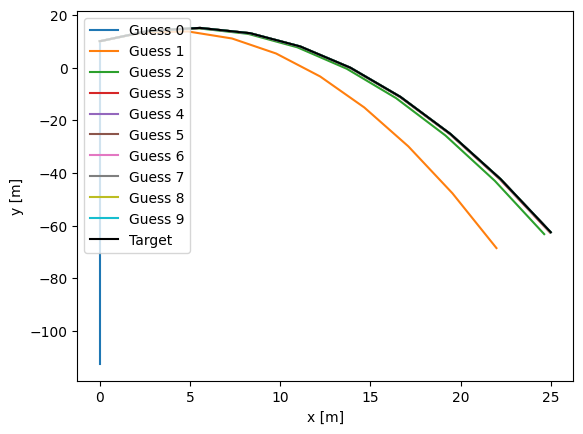

In [36]:
for step, traj in enumerate(training_path):
    plt.plot(traj[:, 0], traj[:, 1], label=f'Guess {step}')
plt.plot(trajectory_target[:, 0], trajectory_target[:, 1], c='k', label='Target')
plt.legend(loc='upper left')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.show()

As expected from the loss, we get closer to the target trajectory with each iteration. Looking at the values of v0:

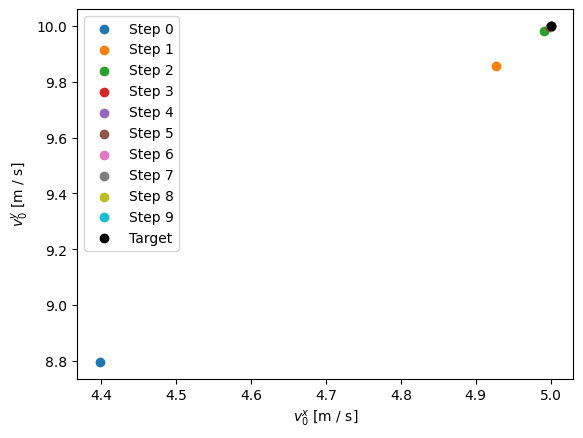

In [37]:
for i_step, step in enumerate(v0_steps):
    plt.scatter(step[:, 0], step[:, 1], label=f'Step {i_step}')
plt.scatter(5, 10, c='k', label='Target')
plt.legend(loc='upper left')
plt.xlabel('$v_{0}^{x}$ [m / s]')
plt.ylabel('$v_{0}^{y}$ [m / s]')
plt.show()

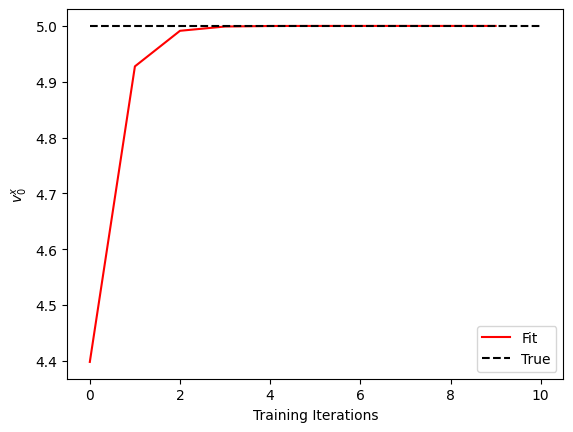

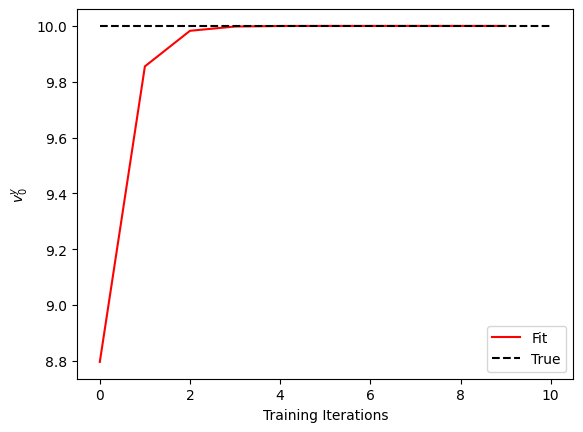

In [38]:
plt.plot(torch.cat(v0_steps)[:, 0], c='r', label='Fit')
plt.plot([0, len(v0_steps)], [v0_target[0][0]]*2, c='k', ls='dashed', label='True')
plt.xlabel('Training Iterations')
plt.ylabel('$v_{0}^x$')
plt.legend()
plt.show()

plt.plot(torch.cat(v0_steps)[:, 1], c='r', label='Fit')
plt.plot([0, len(v0_steps)], [v0_target[0][1]]*2, c='k', ls='dashed', label='True')
plt.xlabel('Training Iterations')
plt.ylabel('$v_{0}^y$')
plt.legend()
plt.show()

we recover the target parameters.

## Slightly more complicated -- more parameters!

Let's try to fit all parameters! The training loop is basically the same, just with more.

### Exercise 2: Fill in the gaps for the other parameters

In [39]:
# Initialize training parameters. This time we want gradients for a, x0, and v0
v0_guess = torch.tensor([0., 0.])[None, :]
v0_guess.requires_grad = True

a_guess = torch.tensor([0., 0.])[None, :]
a_guess.requires_grad = True

x0_guess = torch.tensor([0., 0.])[None, :]
x0_guess.requires_grad = True
# Learning rate -- controls the size of the optimization step
lr = 1e-2

# Keep track of training and losses 
training_path = []
losses = []

# Do 10 parameter updates
for epoch in range(1000):   
    
    for param in [v0_guess, x0_guess, a_guess]:
        if param.grad is not None:
            param.grad.zero_()

    # Guess with current parameters
    trajectory_guess = position(time_steps, a_guess, x0_guess, v0_guess)
    
    # Calculate loss
    loss = ((trajectory_target - trajectory_guess)**2).mean()
    
    # Compute gradients
    loss.backward()

    print(f"Iter {epoch}, Loss: {loss.detach().item()}")
    
    # Update for next loop -- simultaneous update of all three
    with torch.no_grad():
        v0_guess -= lr*v0_guess.grad
        # Add in a_guess, x0_guess

    # Store training history.
    training_path.append(trajectory_guess.detach())
    losses.append(loss.detach())

Iter 0, Loss: 470.8349609375
Iter 1, Loss: 421.08892822265625
Iter 2, Loss: 379.7095642089844
Iter 3, Loss: 345.2897644042969
Iter 4, Loss: 316.6590270996094
Iter 5, Loss: 292.8435974121094
Iter 6, Loss: 273.0336608886719
Iter 7, Loss: 256.5555114746094
Iter 8, Loss: 242.84884643554688
Iter 9, Loss: 231.4474334716797
Iter 10, Loss: 221.963623046875
Iter 11, Loss: 214.0749053955078
Iter 12, Loss: 207.512939453125
Iter 13, Loss: 202.0546112060547
Iter 14, Loss: 197.51437377929688
Iter 15, Loss: 193.7377166748047
Iter 16, Loss: 190.59622192382812
Iter 17, Loss: 187.98312377929688
Iter 18, Loss: 185.8094940185547
Iter 19, Loss: 184.00149536132812
Iter 20, Loss: 182.49752807617188
Iter 21, Loss: 181.2465362548828
Iter 22, Loss: 180.20591735839844
Iter 23, Loss: 179.34034729003906
Iter 24, Loss: 178.62033081054688
Iter 25, Loss: 178.02145385742188
Iter 26, Loss: 177.52328491210938
Iter 27, Loss: 177.10890197753906
Iter 28, Loss: 176.76419067382812
Iter 29, Loss: 176.47747802734375
Iter 30, L

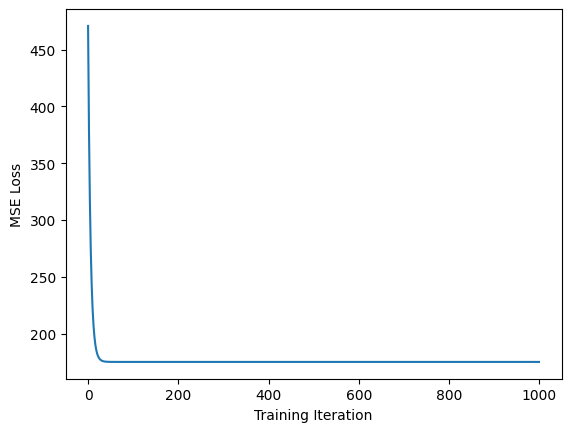

In [40]:
plt.plot(losses)
plt.xlabel('Training Iteration')
plt.ylabel('MSE Loss')
plt.show()

### Uh oh! Something went wrong! The loss should be going down!

Usually when this happens, the learning rate is too big -- the optimization procedure doesn't converge to a minimum because we're "bouncing around" the parameter space.

#### Solutions:
1. Guess and check: try decreasing learning rate. Often helpful to look at the magnitude of the corresponding gradients to get an idea of appropriate magnitudes
2. Use a better optimizer (e.g. something adaptive like Adam)

In our case, guessing should be sufficient. Note that _decreasing_ the size of our update steps means that we should _increase_ the number of training iterations.

In [41]:
# Initialize training parameters. This time we want gradients for a, x0, and v0
a_guess = torch.tensor([0., 0.])[None, :]
x0_guess = torch.tensor([0.,0.])[None, :]
v0_guess = torch.tensor([0., 0.])[None, :]

a_guess.requires_grad = True
x0_guess.requires_grad = True
v0_guess.requires_grad = True

# Learning rate -- controls the size of the optimization step: decrease from 0.1 to 0.01
lr = 0.01

# Keep track of training and losses 
training_path = []
losses = []

# Do 10 parameter updates
for epoch in tqdm(range(10000)):   
    
    for param in [v0_guess, x0_guess, a_guess]:
        if param.grad is not None:
            param.grad.zero_()

    # Guess with current parameters
    trajectory_guess = position(time_steps, a_guess, x0_guess, v0_guess)
    
    # Calculate loss
    loss = ((trajectory_target - trajectory_guess)**2).mean()
    
    # Compute gradients
    loss.backward()
    
    # Update for next loop -- simultaneous update of all three
    with torch.no_grad():
        v0_guess -= lr*v0_guess.grad
        x0_guess -= lr*x0_guess.grad
        a_guess -= lr*a_guess.grad

    # Store training history.
    training_path.append(trajectory_guess.detach())
    losses.append(loss.detach())

100%|██████████| 10000/10000 [00:01<00:00, 5684.94it/s]


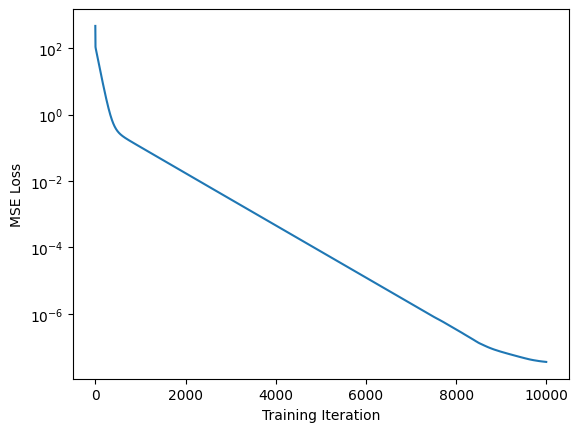

In [42]:
plt.plot(losses)
plt.xlabel('Training Iteration')
plt.ylabel('MSE Loss')
plt.yscale('log')
plt.show()

In [43]:
print(losses[-1])

tensor(3.5767e-08)


Much healthier!

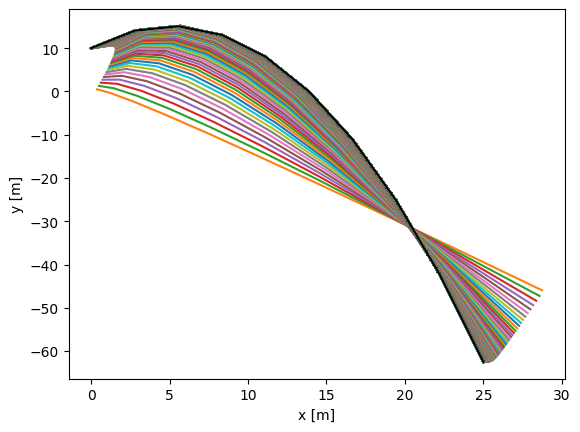

In [44]:
for step, traj in enumerate(training_path):
    if step % 10 == 0:
        plt.plot(traj[:, 0], traj[:, 1], label=f'Guess {step}')
plt.plot(trajectory_target[:, 0], trajectory_target[:, 1], c='k', label='Target')
#plt.legend()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.show()

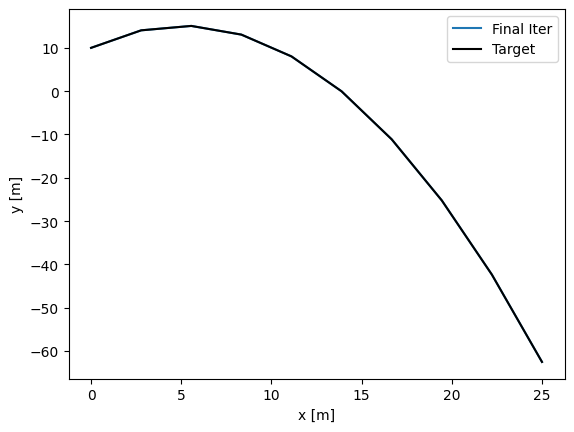

In [45]:
plt.plot(training_path[-1][:, 0], training_path[-1][:, 1], label='Final Iter')
plt.plot(trajectory_target[:, 0], trajectory_target[:, 1], c='k', label='Target')
plt.legend()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.show()

In [46]:
print(f'Final v0: {v0_guess.detach()[0]}, Target: {v0_target[0]}')
print(f'Final x0: {x0_guess.detach()[0]}, Target: {x0_target[0]}')
print(f'Final a: {a_guess.detach()[0]}, Target: {a_target[0]}')

Final v0: tensor([4.9997, 9.9995]), Target: tensor([ 5, 10])
Final x0: tensor([2.7439e-04, 1.0001e+01]), Target: tensor([ 0, 10])
Final a: tensor([ 8.8937e-05, -9.7998e+00]), Target: tensor([ 0.0000, -9.8000])


## Cleaning up
We've manually defined our loss function and optimizer, but using built in PyTorch stuff generalizes much better! Rewriting:

In [47]:
# Same MSE loss from PyTorch
loss_fn = torch.nn.MSELoss()

# If we want to initialize at 0's we should use torch.zeros
a_guess = torch.zeros((1, 2), requires_grad=True)
x0_guess = torch.zeros((1, 2), requires_grad=True)
v0_guess = torch.zeros((1, 2), requires_grad=True)

# Torch has a bunch of built in optimizers. Stick with gradient descent.
optimizer = torch.optim.SGD([a_guess, x0_guess, v0_guess], lr=0.01)

# Same simple history tracking
training_path = []
losses = []
for epoch in tqdm(range(10000)):
    # This line replaces the per-parameter gradient zeroing
    optimizer.zero_grad()
    
    # Forward model done the same way
    trajectory_guess = position(time_steps, a_guess, x0_guess, v0_guess)
    
    # Pass to loss function
    loss = loss_fn(trajectory_target, trajectory_guess)
    
    # Backward pass done the same way
    loss.backward()

    # The optimizer takes care of the gradient steps
    optimizer.step()
        
    losses.append(loss.detach())
    training_path.append(trajectory_guess.detach())

100%|██████████| 10000/10000 [00:02<00:00, 3782.65it/s]


Results are completely identical

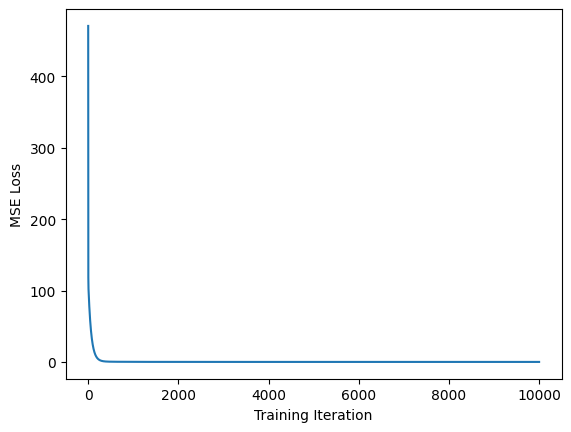

In [48]:
plt.plot(losses)
plt.xlabel('Training Iteration')
plt.ylabel('MSE Loss')
plt.show()

In [49]:
print(losses[-1])

tensor(3.5790e-08)


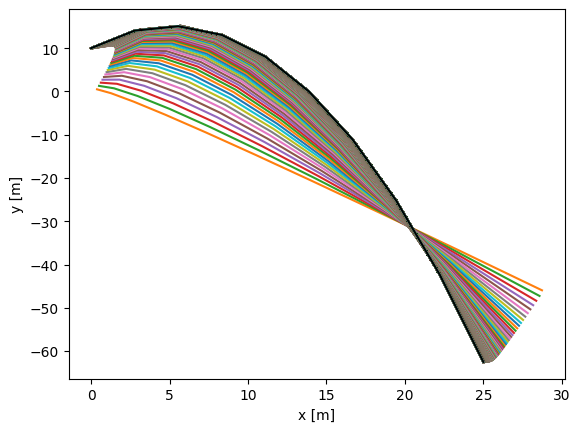

In [50]:
for step, traj in enumerate(training_path):
    if step % 10 == 0:
        plt.plot(traj[:, 0], traj[:, 1], label=f'Guess {step}')
plt.plot(trajectory_target[:, 0], trajectory_target[:, 1], c='k', label='Target')
#plt.legend()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.show()

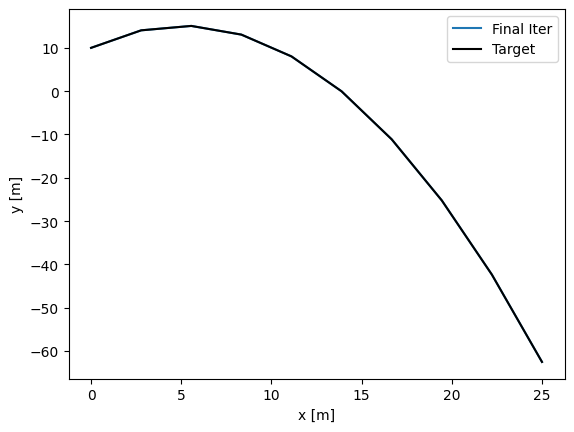

In [51]:
plt.plot(training_path[-1][:, 0], training_path[-1][:, 1], label='Final Iter')
plt.plot(trajectory_target[:, 0], trajectory_target[:, 1], c='k', label='Target')
plt.legend()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.show()

In [52]:
print(f'Final v0: {v0_guess.detach()[0]}, Target: {v0_target[0]}')
print(f'Final x0: {x0_guess.detach()[0]}, Target: {x0_target[0]}')
print(f'Final a: {a_guess.detach()[0]}, Target: {a_target[0]}')

Final v0: tensor([4.9997, 9.9995]), Target: tensor([ 5, 10])
Final x0: tensor([2.7463e-04, 1.0001e+01]), Target: tensor([ 0, 10])
Final a: tensor([ 8.8973e-05, -9.7998e+00]), Target: tensor([ 0.0000, -9.8000])


Using PyTorch built-ins let's us easily explore other optimizers (e.g. Adam)

In [53]:
# Same MSE loss from PyTorch
loss_fn = torch.nn.MSELoss()

# If we want to initialize at 0's we should use torch.zeros
a_guess = torch.zeros((1, 2), requires_grad=True)
x0_guess = torch.zeros((1, 2), requires_grad=True)
v0_guess = torch.zeros((1, 2), requires_grad=True)

# Torch has a bunch of built in optimizers. Stick with gradient descent.
optimizer = torch.optim.Adam([a_guess, x0_guess, v0_guess], lr=1)

# Same simple history tracking
training_path = []
losses = []
for epoch in tqdm(range(1000)):
    # This line replaces the per-parameter gradient zeroing
    optimizer.zero_grad()
    
    # Forward model done the same way
    trajectory_guess = position(time_steps, a_guess, x0_guess, v0_guess)
    
    # Pass to loss function
    loss = loss_fn(trajectory_target, trajectory_guess)
    
    # Backward pass done the same way
    loss.backward()

    # The optimizer takes care of the gradient steps
    optimizer.step()
        
    losses.append(loss.detach())
    training_path.append(trajectory_guess.detach())

100%|██████████| 1000/1000 [00:00<00:00, 2785.53it/s]


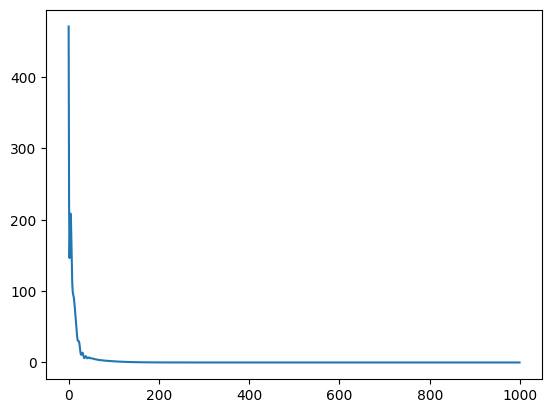

In [54]:
plt.plot(losses)
plt.show()

In [55]:
print(f'Final v0: {v0_guess.detach()[0]}, Target: {v0_target[0]}')
print(f'Final x0: {x0_guess.detach()[0]}, Target: {x0_target[0]}')
print(f'Final a: {a_guess.detach()[0]}, Target: {a_target[0]}')

Final v0: tensor([ 5.0000, 10.0000]), Target: tensor([ 5, 10])
Final x0: tensor([-3.5458e-07,  1.0000e+01]), Target: tensor([ 0, 10])
Final a: tensor([-2.0465e-07, -9.8000e+00]), Target: tensor([ 0.0000, -9.8000])


## Tips and Tricks: Hard Edges and You

We now know how to fit parameters of a physics simulation using differentiable programming. But...our simulation is quite simple. What happens if it is more complex? What about if it's not trivially differentiable? 


Let's walk through an example where we want to make a cut on an observable to maximize a single binned significance ("cut and count"). For simplicity, we set this up as follows:


Suppose we have 500 total signal events ($s$) and 10000 total background events ($b$) with mass distributions peaked in distinct spots ($\mathbb{E}[m_{s}] = 1100$ GeV and $\mathbb{E}[m_{b}] = 700$ GeV). We want to find a cut value on $m$ that maximizes $s/\sqrt{b}$.

In [56]:
# Create the toy data
n_s = 500
n_b = 10000

torch.random.manual_seed(3)
m_s = 1000*torch.normal(torch.ones(n_s)*0.6, torch.ones(n_s)*0.05)+500
m_b = 1000*torch.normal(torch.ones(n_b)*0.2, torch.ones(n_b)*0.3)+500

# Concatenate to one vector of observable values
all_ms = torch.cat([m_s, m_b])

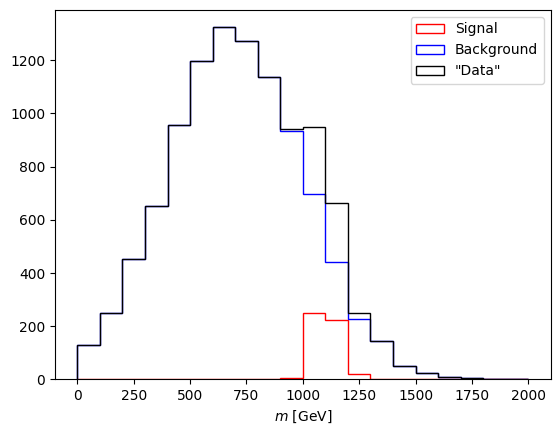

In [57]:
# Plot the distributions
plt.hist(m_s.numpy(), bins=20, range=[0, 2000], histtype='step', edgecolor='r', label='Signal')
plt.hist(m_b.numpy(), bins=20, range=[0, 2000], histtype='step', edgecolor='b', label='Background')

plt.hist(all_ms.numpy(),  bins=20, range=[0, 2000], histtype='step', edgecolor='k', label='"Data"')
plt.xlabel('$m$ [GeV]')
plt.legend()
plt.show()

We want to make a cut and maximize $s/\sqrt{b}$ for the remaining events. As an example:

In [58]:
# Pick a cut value
a = torch.tensor(500.)

# Number of signal events passing cut
n_s_pass = (m_s >= a).sum()

# Number of background events passing cut
n_b_pass = (m_b >= a).sum()

# s/sqrt(b)
print(n_s_pass/torch.sqrt(n_b_pass))

tensor(5.7862)


This is a 1D example, so we can construct the ground truth by just sweeping over values:

In [59]:
test_as = torch.linspace(500, 1500, 10000)

### Exercise 3: vectorization

Remember our trick from before of adding singular `x[None, :]` type dimensions to make shapes work out. 

Specifically, we wanted to calculate over all time steps and each spatial dimension at the same time, so we had shapes like:
```
#Start at (0,10) [m]
x0_target = torch.tensor([0,10])[None, :]

#Data taken at 10 known timesteps from 0 to 5 s
time_steps = torch.linspace(0, 5, 10)[:, None]
```

so that we ended up with a tensor of shape (n_time_steps, n_space) = (10, 2)

Can we calclulate `n_s` in a similar way to compare all values of `m_s` with all cuts (values of `test_as`)? 

Specifically, we want to end up with a tensor of shape `(len(m_s), len(test_as))` which we can then sum over `dim=0`.

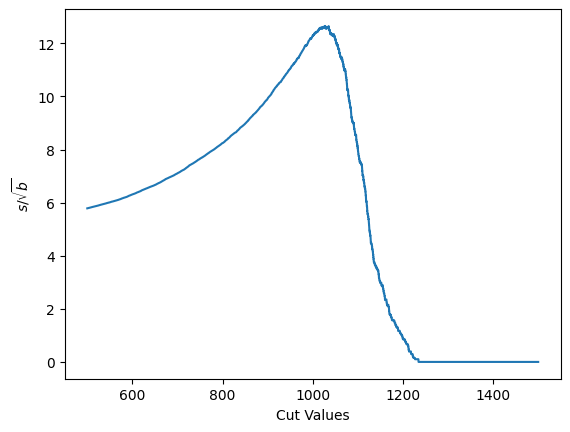

Best cut: 1027.4527587890625, s/sqrt(b): 12.658792495727539


In [60]:
# fill in lines for all_n_s and all_n_b
all_n_s = (m_s[:, None] >= test_as[None, :])
all_n_s = all_n_s.sum(dim=0)

all_n_b = (m_b[:, None] >= test_as[None, :])
all_n_b = all_n_b.sum(dim=0)


all_sig = all_n_s/torch.sqrt(all_n_b)

plt.plot(test_as, all_sig)
plt.xlabel('Cut Values')
plt.ylabel('$s/\\sqrt{b}$')
plt.show()

best_idx = torch.argmax(all_sig)
print(f'Best cut: {test_as[best_idx]}, s/sqrt(b): {all_sig[best_idx]}')

### Problem statement:
Can we use differentiable programming + gradient-based optimization to find the cut value that maximizes $s/\sqrt{b}$?


Let's break down the function that we're trying to optimize (remember, autodiff is the chain rule).


For a given value of cut $a$, event with mass $m$, we first need to check if $m$ > $a$. If yes, it contributes to the event count, if no, it doesn't.

One way of representing this is via a piecewise function
\begin{equation}
    p(m) = 
    \begin{cases} 
      1 & m \geq a \\
      0 & m < a
    \end{cases}
\end{equation}

Plotting:

In [ ]:
a = 500.
m_vals = torch.linspace(0, 2000, 1000)

plt.plot(m_vals, (m_vals>=a).int())
plt.xlabel('$m$ [GeV]')
plt.ylabel('$p(m)$')
plt.show()

This is the form of the [Heaviside step function](https://en.wikipedia.org/wiki/Heaviside_step_function).

One problem: what is the derivative, $\frac{dp(m)}{dm}$? If we look at the form of the function, we see it's 0 everywhere (and infinite at one point) -- not very useful for optimization!

On the code side, there's also a bit of an issue

In [ ]:
# Pick a cut value
a = torch.tensor(500., requires_grad=True)

# Number of signal events passing cut
n_s_pass = (m_s >= a).sum()

# Number of background events passing cut
n_b_pass = (m_b >= a).sum()

# s/sqrt(b)
print(n_s_pass/torch.sqrt(n_b_pass))

Usually we have an associated grad_fn, e.g.:

In [ ]:
a*2

But that's not the case here (and for good reason). One common approach to this type of issue is to use some _relaxation_ of the hard edge/discrete cut -- some function with nicer derivatives that is close to (but not exactly) the function of interest.

For step-function like functions, a good choice is the sigmoid:

\begin{equation}
S_{k}(x) = \frac{1}{1+e^{-k\cdot x}}
\end{equation}

where $k$ is a rate parameter that controls the steepness of the transition from 0 to 1.

In [ ]:
def soft_gt(x, a, rate=1.):
    return torch.sigmoid(rate*(x-a))

In [ ]:
a = 500.
m_vals = torch.linspace(0, 2000, 1000)

plt.plot(m_vals, (m_vals>=a))
for rate in [1e-3, 1e-2, 0.1, 1, 10]:
    plt.plot(m_vals, soft_gt(m_vals, a, rate=rate), label=f'k={rate}')
plt.xlabel('$m$ [GeV]')
plt.ylabel('$p(m)$')
plt.legend()
plt.show()

We can tune the rate parameter to trade off between accuracy (how close we are to the hard cut) and smoothness (how good the gradients are).



In context:

In [ ]:
# Choose some rate (may need to adjust)
rate=10.

# Calculate s/sqrt(b) with the soft greater than
all_n_s_soft = soft_gt(m_s[:, None], test_as[None, :], rate=rate).sum(dim=0)
all_n_b_soft = soft_gt(m_b[:, None], test_as[None, :], rate=rate).sum(dim=0)

all_sig_soft = all_n_s_soft/torch.sqrt(all_n_b_soft)

# Compare to the exact version
plt.plot(test_as, all_sig, label='Exact')
plt.plot(test_as, all_sig_soft, label='Softened')
plt.ylabel("$s/\\sqrt{b}$")
plt.xlabel("Cut Value [GeV]")
plt.show()
print(f'Best cut, soft: {test_as[np.argmax(all_sig_soft)]}, true sig: {all_sig[np.argmax(all_sig_soft)]}')
print(f'Best cut, exact: {test_as[np.argmax(all_sig)]}, true sig: {all_sig[np.argmax(all_sig)]}')

Let's check that gradients flow now:

In [ ]:
rate=10.
# Pick a cut value
a = torch.tensor(500., requires_grad=True)

# Number of signal events passing cut
n_s_pass_soft = soft_gt(m_s, a, rate=rate).sum()

# Number of background events passing cut
n_b_pass_soft = soft_gt(m_b, a, rate=rate).sum()

# s/sqrt(b)
print(n_s_pass_soft/torch.sqrt(n_b_pass_soft))

Success! Let's try running an optimization:

### Exercise 4: Fill in the loop

Translate the previous cell into an optimization loop, similar to above. 

In [ ]:
# Initial guess

# Optimizer: suggest using Adam with lr=1, parameter to optimize should be passed as list [a]

# History tracking
a_history = []
losses = []
for epoch in tqdm(range(2000)):
    # Zero out the gradients
    
    
    # Calculate s/sqrt(b)
    # First do n_s using soft_gt(m_s, a, rate=rate).sum()

    # Then calculate n_b similarly with m_b

    # Then s/torch.sqrt(b)
    
    # Finally set up a loss function. Remember this is a minimization loop
    # What's a simple loss function to maximize s/sqrt(b)

    # Calculate gradients with backward pass

    # Step with optimizer

        
    # Keep track of history
    losses.append(loss.item())
    a_history.append(a.item())

In [ ]:
plt.plot(losses)
plt.show()
plt.plot(a_history)
plt.show()
print('Converged:', a_history[-1], -losses[-1])
print('Sweep:', test_as[torch.argmax(all_sig)].item(), all_sig[torch.argmax(all_sig)].item())

In [ ]:
a_fit = a_history[-1]

# Number of signal events passing fit cut
n_s_pass_fit = (m_s >= a_fit).sum()

# Number of background events passing fit cut
n_b_pass_fit = (m_b >= a_fit).sum()

# s/sqrt(b)
print(f'True sig. at fit cut: {(n_s_pass_fit/torch.sqrt(n_b_pass_fit)).item()}')

In [ ]:
plt.hist(m_s.numpy(), bins=20, range=[0, 2000], edgecolor='r', histtype='step', label='Signal')
plt.hist(m_b.numpy(), bins=20, range=[0, 2000], edgecolor='b', histtype='step', label='Background')

plt.hist(all_ms.numpy(),  bins=20, range=[0, 2000], edgecolor='k', histtype='step', label='"Data"')

plt.plot([a_history[-1]]*2, [0, 1400], label='Best Fit', c='cyan')
plt.plot([test_as[best_idx]]*2, [0, 1400], label='Best Scan', c='gold')
plt.legend()
plt.show()

### Exercises for later:

1) Impact of the rate: How big can you make the rate before the optimization breaks? What happens to accuracy as you make the rate smaller?

2) In 1D this is really a toy problem, but what about in N-D? Consider a system defined by two masses, e.g.
```
    m_s1 = 1000*torch.normal(torch.ones(n_s)*0.6, torch.ones(n_s)*0.05)+500
    m_s2 = 1000*torch.normal(torch.ones(n_s)*0.5, torch.ones(n_s)*0.1)+500
    
    m_b1 = 1000*torch.normal(torch.ones(n_b)*0.2, torch.ones(n_b)*0.3)+500
    m_b2 = 1000*torch.normal(torch.ones(n_b)*0.1, torch.ones(n_b)*0.4)+500
```
Can you run the same sort of analysis?


## Bonus: Differentiable Pipelines

Writing differentiable physics code can be an excellent tool all on its own. However, linking physics code with other pieces of a machine learning pipeline, such as neural networks, can be a poweful tool as well. 

As a simple example, let's come back to our kinematic equation. Suppose we have a pitching machine that fires baseballs in a place with known acceleration, but with an initial velocity and position that become miscalibrated as the day goes on.

Let's say we want to develop a prediction for the final position of the baseballs as a function of time of day.

There are two ways one could do this: 

1) Train a model to go from time of day to final position

2) Train a model to go from time of day to initial position + velocity, use our differentiable simulator to propagate to the final position. 

### What's the point?

Let's reduce to 1D for simplicity. Assume 

In [ ]:
#Acceleration due to gravity (-9.8 m/s^2 in negative y direction)
a = torch.tensor(-9.8)

#Initial velocity for fun (m / s)
v0_start = torch.tensor(10)

#Start at 10 [m]
x0_start = torch.tensor(15)

# End time: assume this is fixed
t_end = torch.tensor(3)

We define the position function as before

In [ ]:
def position(t, a, x0, v0):
    return x0 + v0*t + 0.5*a*t**2

And now introduce some drift in v0 and x0. For simplicity, let's assume that t_launch (the time of day we're launching) runs from 0 to 1.

In [ ]:
def v0_drift(t_launch):
    return 5*t_launch**2

def x0_drift(t_launch):
    return 2*torch.sin(20*t_launch)

Set up some training data for launching

In [ ]:
all_t_launch = torch.linspace(0, 1, 100)
all_v0_drift = v0_drift(all_t_launch)
all_x0_drift = x0_drift(all_t_launch)

all_end = position(t_end, a, x0_start+all_x0_drift, v0_start+all_v0_drift)

Now the ending position as a function of launch time is some convoluted function:

In [ ]:
plt.plot(all_t_launch, all_end)
plt.xlabel('Launch Time')
plt.ylabel('Ending Position')
plt.show()

But the drift functions are relatively simple:

In [ ]:
plt.plot(all_t_launch, all_x0_drift)
plt.xlabel('Launch Time')
plt.ylabel('x0 Drift')
plt.show()
plt.plot(all_t_launch, all_v0_drift)
plt.xlabel('Launch Time')
plt.ylabel('v0 Drift')
plt.show()

### Claim: Modeling the underlying variables may make it easier to model the objective

Let's test this out with some simple MLPs.


First, let's set up a network to directly model the end position drift:

In [ ]:
from torch import nn

class MLP_direct(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layers = nn.Sequential(
                          nn.Linear(1, 100),
                          nn.ReLU(),
                          nn.Linear(100, 50),
                          nn.ReLU(),
                          nn.Linear(50, 1)
                        )


    def forward(self, x):
        out = self.layers(x)
        return out

Our inputs are the launch times, targets are the end positions:

In [ ]:
inputs = all_t_launch[:, None]
targets = all_end[:, None]

Traning loop should be pretty standard

In [ ]:
# Initialize the MLP
torch.random.manual_seed(3)
mlp = MLP_direct()

# Define the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)

# Run the training loop
losses = []
predictions_direct = []
for epoch in tqdm(range(4000)): 

    # Zero the gradients
    optimizer.zero_grad()

    # Perform forward pass
    outputs = mlp(inputs)

    # Compute loss
    loss = loss_fn(outputs, targets)

    # Perform backward pass
    loss.backward()

    # Perform optimization
    optimizer.step()
    
    losses.append(loss.item())
    predictions_direct.append(outputs.flatten().clone().detach())

In [ ]:
plt.plot(losses)
plt.xlabel('Training Iteration')
plt.ylabel('Losses')
plt.show()

In [ ]:
plt.plot(all_t_launch, predictions_direct[-1], c='r', label='Fit')
plt.plot(all_t_launch, all_end, c='k', label='True')
plt.legend()
plt.xlabel('Launch Time')
plt.ylabel('End Position')
plt.show()

Not too bad (and we could probably make it better with tweaking) but misses some fine structure!


Now with differentiable programming, we model the drift and propagate it through:

In [ ]:
from torch import nn

class MLP_drift(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layers = nn.Sequential(
                          nn.Linear(1, 100),
                          nn.ReLU(),
                          nn.Linear(100, 50),
                          nn.ReLU(),
                          nn.Linear(50, 2)
                        )


    def forward(self, x):
        out = self.layers(x)
        return out

Our inputs will be the launch times and our targets will still be the end positions.

In [ ]:
inputs = all_t_launch[:, None]
targets = all_end[:, None]

Training loop is the same, but with an extra step in the middle!

### Exercise 5: Fill in the extra step!

In [ ]:
# Initialize the MLP
torch.random.manual_seed(3)
mlp = MLP_drift()

# Define the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)

# Run the training loop
losses = []
pred_x0_drift = []
pred_v0_drift = []
final_pred_drift = []

for epoch in tqdm(range(4000)): 

    # Zero the gradients
    optimizer.zero_grad()

    # Perform forward pass to get drift
    full_drift = mlp(inputs)
    
    x0_drift = full_drift[:, 0]
    v0_drift = full_drift[:, 1]
    
    # Propagate drift through to end position
    # Use the function position, as well as known
    # t_end and a. Shifted x0 is x0_start+x0_drift, similar for v0
    # For shape consistency, we'll need position(...)[:, None]

    # Compute loss


    # Perform backward pass
    loss.backward()

    # Perform optimization
    optimizer.step()
    
    losses.append(loss.item())
    pred_x0_drift.append(x0_drift.flatten().clone().detach())
    pred_v0_drift.append(v0_drift.flatten().clone().detach())
    final_pred_drift.append(pred.flatten().clone().detach())

In [ ]:
plt.plot(losses)
plt.show()

In [ ]:
plt.plot(all_t_launch, final_pred_drift[-1], c='r', label='Fit')
plt.plot(all_t_launch, all_end, c='k', label='True')
plt.legend()
plt.xlabel('Launch Time')
plt.ylabel('End Position')
plt.show()

Not perfect, but much better! Let's see how the parameters look:

In [ ]:
plt.plot(all_t_launch, pred_x0_drift[-1], c='r', label='Fit')
plt.plot(all_t_launch, all_x0_drift, c='k', label='True')
plt.xlabel('Launch Time')
plt.ylabel('x0 Drift')
plt.legend()
plt.show()

plt.plot(all_t_launch, pred_v0_drift[-1], c='r', label='Fit')
plt.plot(all_t_launch, all_v0_drift, c='k', label='True')
plt.xlabel('Launch Time')
plt.ylabel('v0 Drift')
plt.legend()
plt.show()

**Cautionary tale:** model _degeneracies_ may lead to unexpected results! But including physics can still help (e.g. extra (physical) degrees of freedom). Degeneracies may be broken with _additional constraints_.